In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

# Data

In [3]:
tzinfo = timezone("America/Sao_Paulo")

events = [
    {
        "name": "01.Curta",
        "start": pd.Timestamp(
            year=2020, month=1, day=29, hour=13, minute=51, second=59, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=29, hour=14, minute=20, second=25, tzinfo=tzinfo
        ),
    },
    {
        "name": "02.Longa",
        "start": pd.Timestamp(
            year=2020, month=1, day=30, hour=11, minute=16, second=45, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=30, hour=14, minute=55, second=30, tzinfo=tzinfo
        ),
    },
    {
        "name": "03.Revezamento",
        "start": pd.Timestamp(
            year=2020, month=1, day=31, hour=11, minute=23, second=23, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=31, hour=12, minute=27, second=23, tzinfo=tzinfo
        ),
    },
    {
        "name": "04.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=10, minute=15, second=15, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=11, minute=37, second=28, tzinfo=tzinfo
        ),
    },
    {
        "name": "05.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=15, second=9, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=32, second=55, tzinfo=tzinfo
        ),
    },
    {
        "name": "07.Sprint",
        "start": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=58, second=27, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=59, second=9, tzinfo=tzinfo
        ),
    },
]

events = pd.DataFrame(events).set_index('name')
events

,start,end
name,,
01.Curta,2020-01-29 13:51:59-03:00,2020-01-29 14:20:25-03:00
02.Longa,2020-01-30 11:16:45-03:00,2020-01-30 14:55:30-03:00
03.Revezamento,2020-01-31 11:23:23-03:00,2020-01-31 12:27:23-03:00
04.Curta,2020-02-01 10:15:15-03:00,2020-02-01 11:37:28-03:00
05.Curta,2020-02-01 13:15:09-03:00,2020-02-01 13:32:55-03:00
07.Sprint,2020-02-02 11:58:27-03:00,2020-02-02 11:59:09-03:00


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'ESC Duty Cycle': 'esc_d',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_p_in',
 'ESC Input Current': 'esc_i_in',
 'MPPT 1 Input Current': 'mppt1_ii',
 'MPPT 2 Input Current': 'mppt2_ii',
 'MPPT 3 Input Current': 'mppt3_ii',
 'MPPT 4 Input Current': 'mppt4_ii',
 'MPPT 1 Input Voltage': 'mppt1_vi',
 'MPPT 2 Input Voltage': 'mppt2_vi',
 'MPPT 3 Input Voltage': 'mppt3_vi',
 'MPPT 4 Input Voltage': 'mppt4_vi',
 'MPPT 1 Duty Cycle': 'mppt1_d',
 'MPPT 2 Duty Cycle': 'mppt2_d',
 'MPPT 3 Duty Cycle': 'mppt3_d',
 'MPPT 4 Duty Cycle': 'mppt4_d',
 'MPPT 1 Output Current': 'mppt1_io',
 'MPPT 2 Output Current': 'mppt2_io',
 'MPPT 3 Output Current': 'mppt3_io',
 'MPPT 4 Output Current': 'mppt4_io',
 'Solar POA': 'solar_poa',
 'Wind Speed': 'wind_v',
 'Air Temperature': 'air_t'}

'selected columns:'

Index(['batt_v', 'batt_i', 'esc_d', 'motor_w', 'esc_p_in', 'esc_i_in', 'mppt1_ii',
       'mppt2_ii', 'mppt3_ii', 'mppt4_ii', 'mppt1_vi', 'mppt2_vi', 'mppt3_vi',
       'mppt4_vi', 'mppt1_d', 'mppt2_d', 'mppt3_d', 'mppt4_d', 'mppt1_io',
       'mppt2_io', 'mppt3_io', 'mppt4_io', 'solar_poa', 'wind_v', 'air_t'],
      dtype='object')

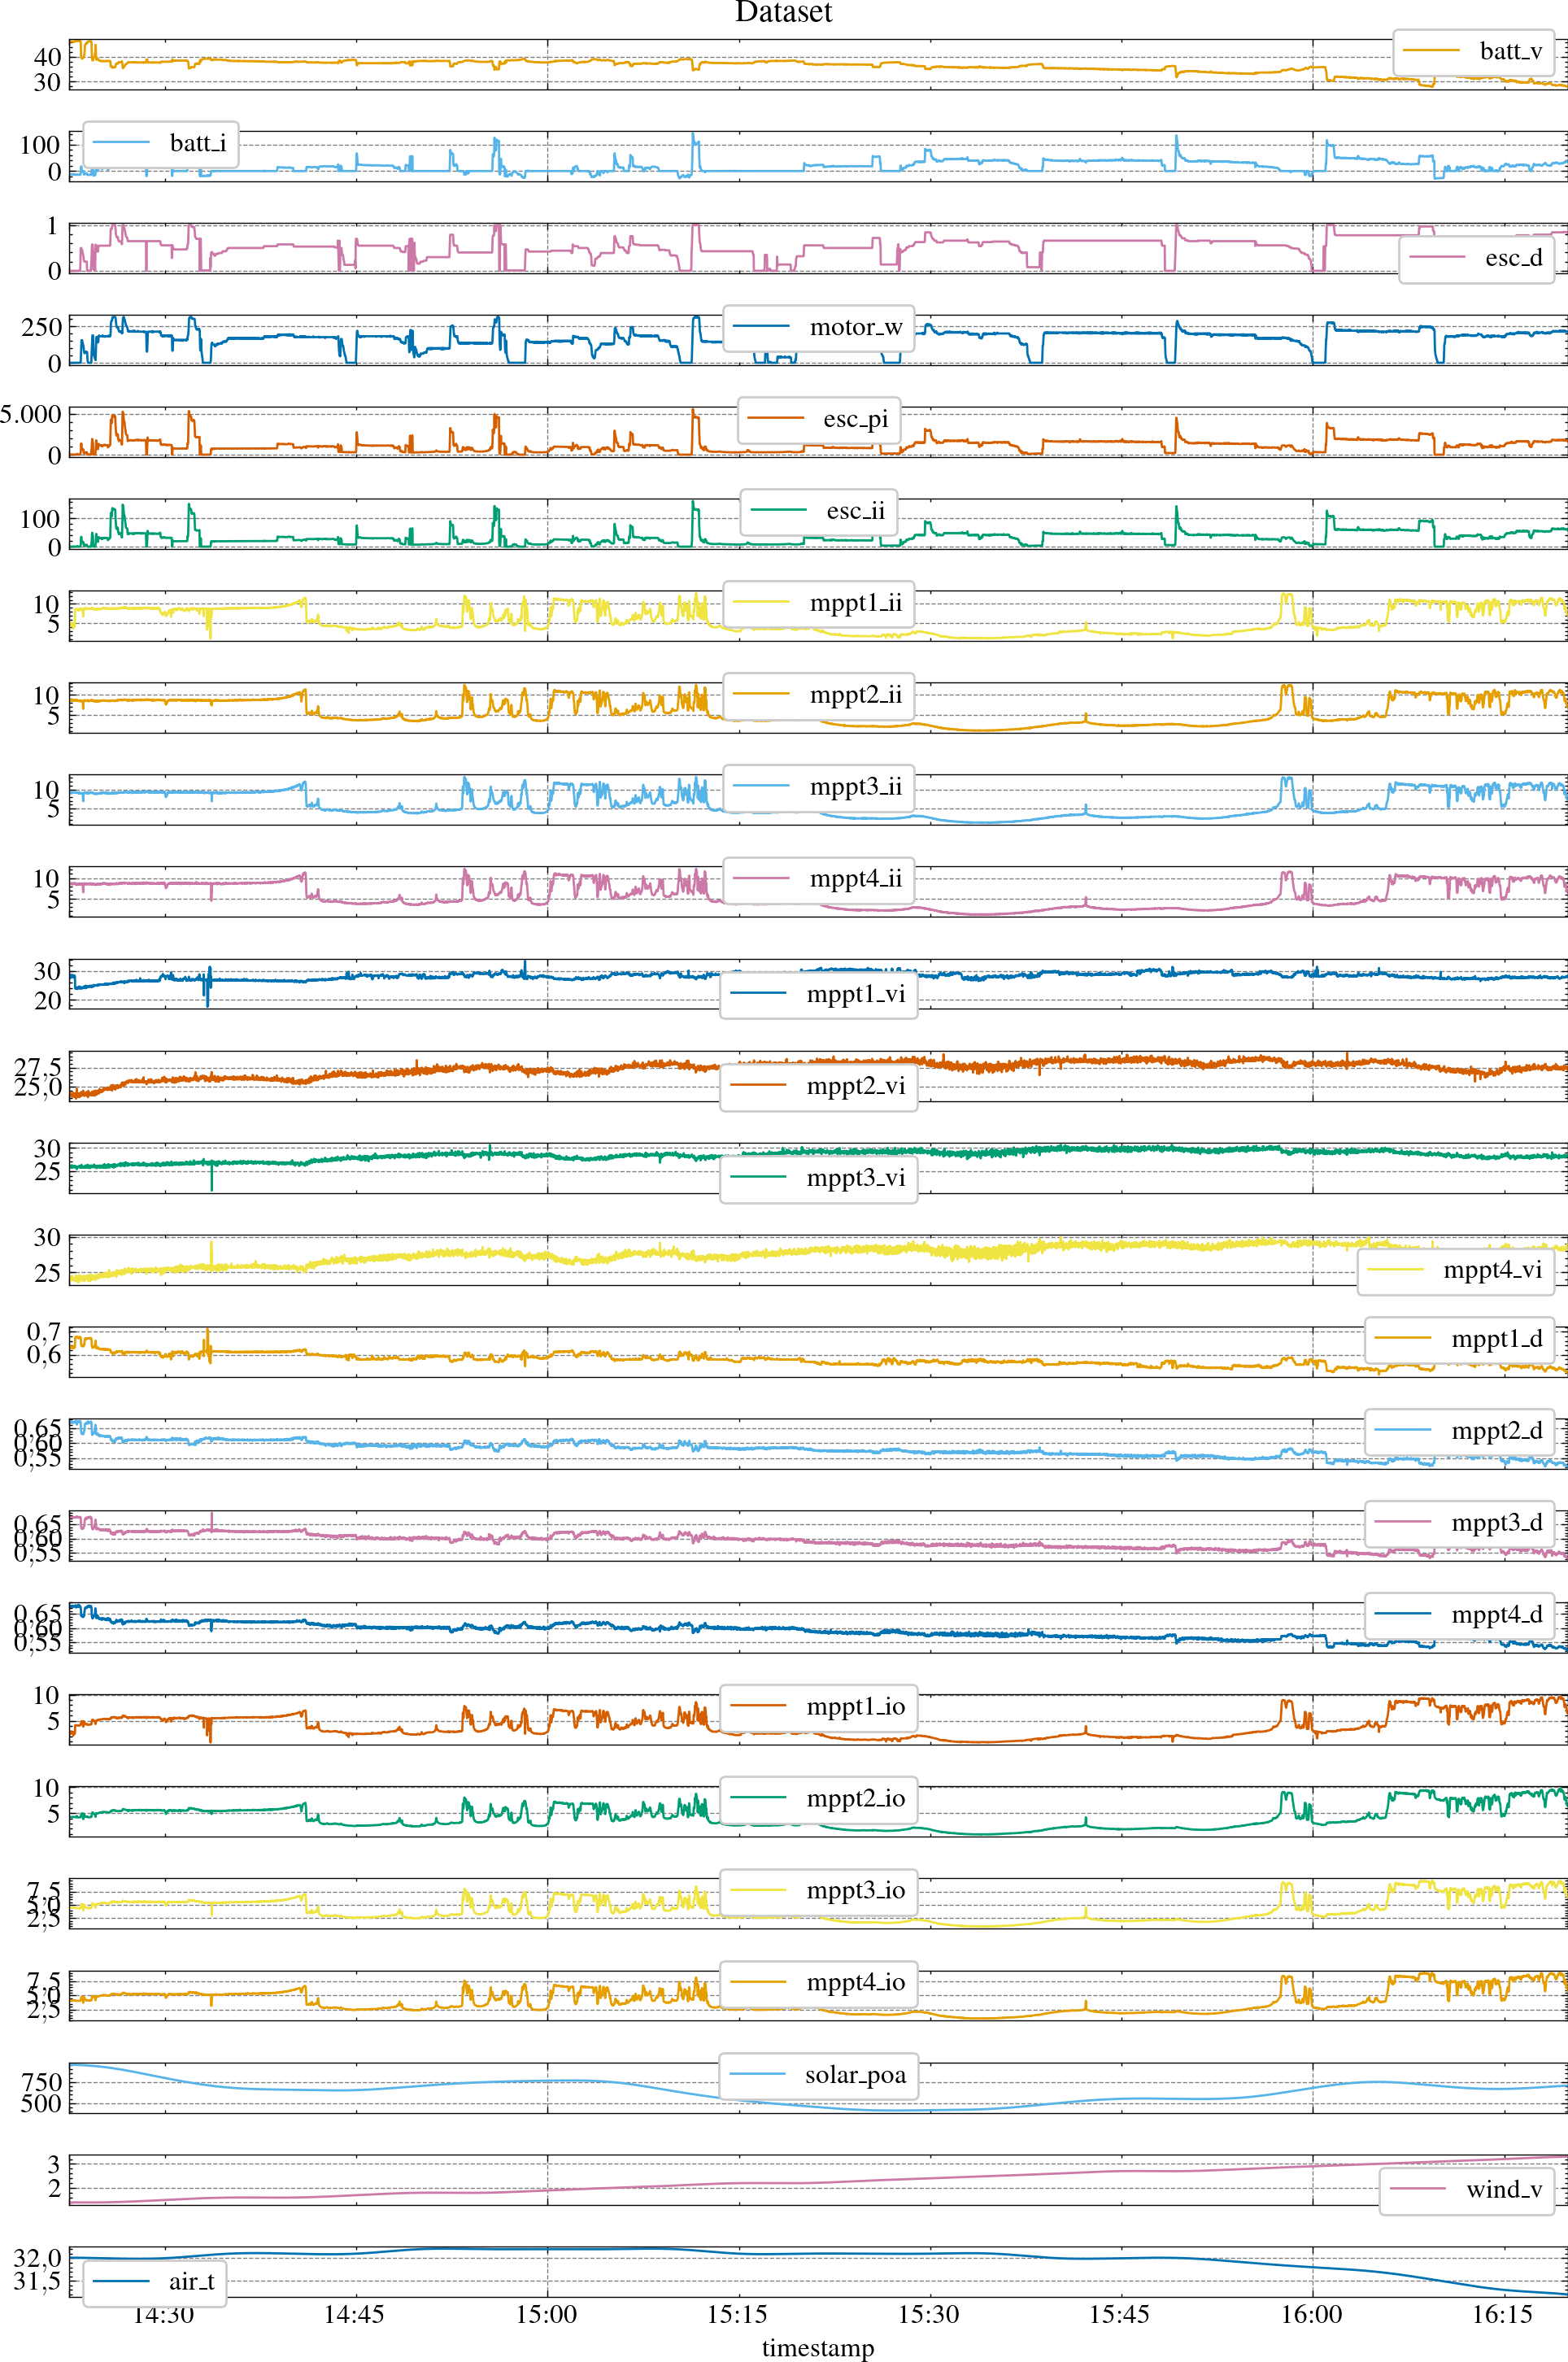

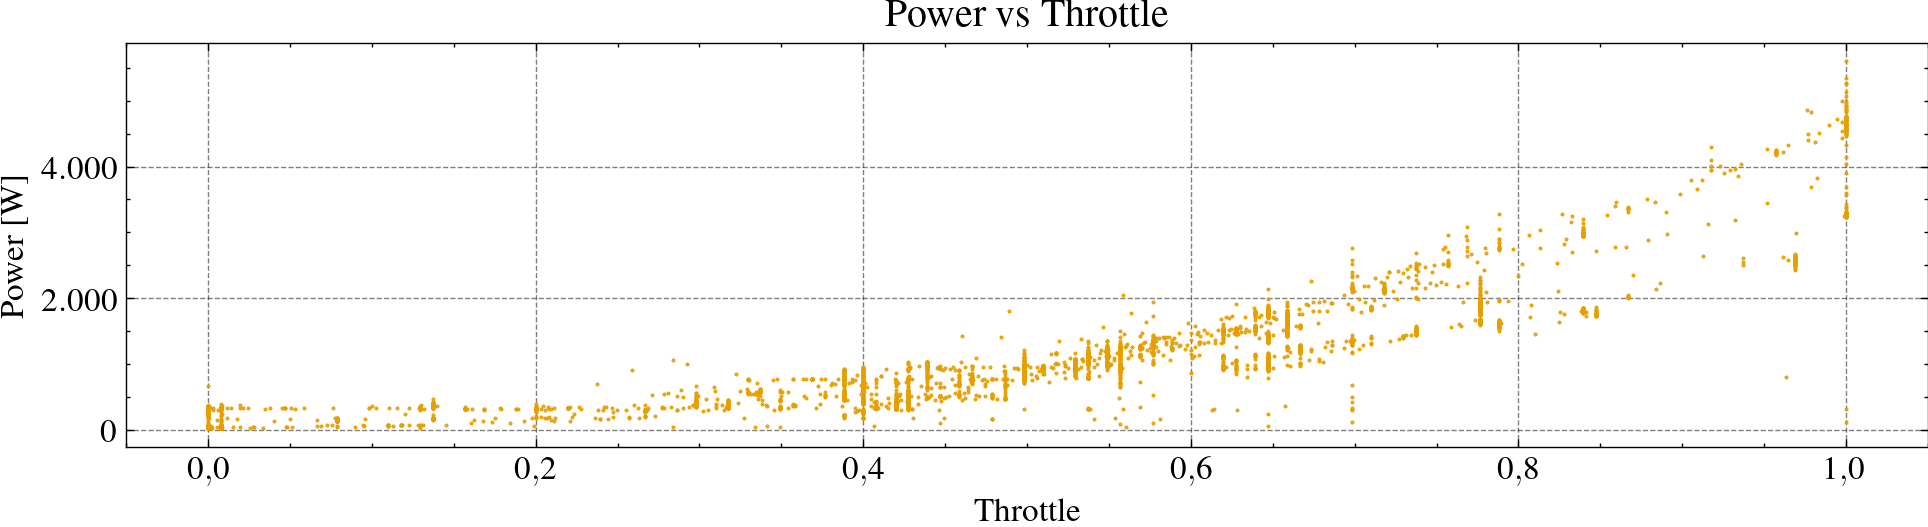

In [4]:
# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=20, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_d',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')
dfa = df.copy(deep=True)

df.plot(subplots=True, figsize=(10, 15))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_d'], df['esc_p_in'], s=0.2)
plt.tight_layout()
plt.show()


# Parameters

In [5]:
from dataclasses import dataclass, asdict
from pprint import pformat, pprint
from copy import deepcopy

propulsion_params = {
    'motor_R_A': 0.04270952220548964,
    'motor_L_A': 0.816092845566883,
    'motor_B': 0.00213137765046113,
    'motor_I_r': 0.003371534938331495,
    'motor_I_r_load': 0.006634350941470065,
    'motor_K_Q': 0.10225268,
    'prop_K_T': 1, # disabled
    'prop_K_Q': 0.0011936690867098046,
    'prop_D': 0.21589999999999998,
    'rho_water': 1025,
    'rho_air': 1.1839,
    'trans_eta': 0.95,
    'esc_eta': 0.8,
    'trans_k': 0.5909090909090909,
    'hull_C_T': 1, # disabled
    'hull_S_air': 1, # disabled
    'hull_S_water': 1, # disabled
}

generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.1589,
    'mppt_eta': 0.9303414194668972,
    'mppts_n': 4,
}

battery_params = { # From: modelling_battery_nonlinear-sprint-dataset.ipynb
    'batt_eta': 1,
    'batt_Q': 38 * 3600,
    'batt_R_0': 0.07688995265604726,
    'batt_R_1': 0.007914593252093682,
    'batt_C_1': 22.97248164632932,
    'batt_k_V_OC_coeffs': [25.4633167882052, 37.126691660372906, -21.115645449324788, -30.02431761749073, 29.382700604694268],
}

others_params = {
    'others_pi': 1.5 * 18, # disabled
}

solar_boat_params = generation_params | battery_params | propulsion_params | others_params
solar_boat_params

{'pv_S': 1.6367999999999998,
 'pv_eta': 0.1589,
 'mppt_eta': 0.9303414194668972,
 'mppts_n': 4,
 'batt_eta': 1,
 'batt_Q': 136800,
 'batt_R_0': 0.07688995265604726,
 'batt_R_1': 0.007914593252093682,
 'batt_C_1': 22.97248164632932,
 'batt_k_V_OC_coeffs': [25.4633167882052,
  37.126691660372906,
  -21.115645449324788,
  -30.02431761749073,
  29.382700604694268],
 'motor_R_A': 0.04270952220548964,
 'motor_L_A': 0.816092845566883,
 'motor_B': 0.00213137765046113,
 'motor_I_r': 0.003371534938331495,
 'motor_I_r_load': 0.006634350941470065,
 'motor_K_Q': 0.10225268,
 'prop_K_T': 1,
 'prop_K_Q': 0.0011936690867098046,
 'prop_D': 0.21589999999999998,
 'rho_water': 1025,
 'rho_air': 1.1839,
 'trans_eta': 0.95,
 'esc_eta': 0.8,
 'trans_k': 0.5909090909090909,
 'hull_C_T': 1,
 'hull_S_air': 1,
 'hull_S_water': 1,
 'others_pi': 27.0}

# Solar Boat System model

In [6]:
import control as ct
from math import sqrt, pi

class SolarBoat:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta, batt_Q, batt_R_1, batt_C_1, motor_R_A, motor_L_A, motor_B, motor_I_r, motor_I_r_load, motor_K_Q = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1'],
            params['batt_C_1'],
            params['motor_R_A'],
            params['motor_L_A'],
            params['motor_B'],
            params['motor_I_r'],
            params['motor_I_r_load'],
            params['motor_K_Q'],
        )

        # States
        batt_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        # batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Outputs
        y = cls._outputs(t, x, u, params)
        batt_i = y[2]
        motor_w = y[6]
        motor_v = y[7]
        motor_Q = y[8]

        # System of differential equations
        d_batt_i_R1 = (batt_i - batt_i_R1)/(batt_C_1*batt_R_1)
        d_batt_z = -batt_eta*batt_i/batt_Q
        d_motor_i = (-motor_K_Q*motor_w - motor_R_A*motor_i + motor_v)/motor_L_A
        d_motor_w = (-motor_B*motor_w + motor_K_Q*motor_i - motor_Q)/(motor_I_r + motor_I_r_load)

        return np.array([d_batt_i_R1, d_batt_z, d_motor_i, d_motor_w])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        pv_S, pv_eta, mppt_eta, mppts_n, batt_R_0, batt_R_1, batt_k_V_OC_coeffs, prop_K_T, prop_K_Q, prop_D, rho_water, rho_air, trans_eta, esc_eta, trans_K, hull_C_T, hull_S_air, hull_S_water, others_pi = (
            params['pv_S'],
            params['pv_eta'],
            params['mppt_eta'],
            params['mppts_n'],
            params['batt_R_0'],
            params['batt_R_1'],
            params['batt_k_V_OC_coeffs'],
            params['prop_K_T'],
            params['prop_K_Q'],
            params['prop_D'],
            params['rho_water'],
            params['rho_air'],
            params['trans_eta'],
            params['esc_eta'],
            params['trans_k'],
            params['hull_C_T'],
            params['hull_S_air'],
            params['hull_S_water'],
            params['others_pi'],
        )

        # Inputs
        pv_g = u[0]  # Total incident irradiance [W/m^2]
        esc_D = u[1]  # ESC duty-cycle

        # States
        batt_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Output equations
        esc_i_in = esc_D*motor_i/esc_eta
        batt_ocv = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(batt_z)
        batt_v = -batt_R_0*esc_i_in/2 - batt_R_1*batt_i_R1/2 + batt_ocv/2 + sqrt(4*batt_R_0*mppt_eta*mppts_n*pv_g*pv_S*pv_eta - 4*batt_R_0*others_pi + (batt_R_0*esc_i_in + batt_R_1*batt_i_R1 - batt_ocv)**2)/2
        others_ii = others_pi/batt_v
        motor_v = batt_v*esc_D
        mppts_i_out = mppt_eta*mppts_n*pv_g*pv_S*pv_eta/batt_v
        batt_i = esc_i_in - mppts_i_out + others_ii
        prop_w = motor_w*trans_K
        prop_Q = prop_D**5*prop_K_Q*prop_w**2*rho_water
        motor_Q = motor_w**2*prop_D**5*prop_K_Q*rho_water*trans_K**3/trans_eta
        hull_V = sqrt(2)*prop_D**2*sqrt(prop_K_T)*prop_w*sqrt(rho_water)/(sqrt(hull_C_T)*sqrt(hull_S_air*rho_air + hull_S_water*rho_water))

        return np.array([batt_v, batt_z, batt_i, mppts_i_out, others_ii, esc_i_in, motor_w, motor_v, motor_Q, prop_w, prop_Q, hull_V])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='boat',
            states=('batt_i_R1', 'batt_SOC', 'motor_i', 'motor_w'),
            inputs=('pv_g', 'esc_D'),
            outputs=('batt_v', 'batt_SOC', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_i_in', 'motor_w', 'motor_v', 'motor_Q', 'prop_w', 'prop_Q', 'hull_V'),
            params=params,
        )

In [7]:
SolarBoat.build(solar_boat_params)

<NonlinearIOSystem:boat:['pv_g', 'esc_D']->['batt_v', 'batt_SOC', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_i_in', 'motor_w', 'motor_v', 'motor_Q', 'prop_w', 'prop_Q', 'hull_V']>

In [8]:
df = dfa.copy(deep=True)#.resample('30min').mean()
# df = df.iloc[:1000]
# df.index[-1] - df.index[0]

In [9]:
# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs
U = df[['solar_poa', 'esc_d']].to_numpy().T

# Model
solar_boat = SolarBoat.build(solar_boat_params)

# Initial state
X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['batt_SOC']] = 1

# Simulation
res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, solve_ivp_method='LSODA', solve_ivp_kwargs=dict(max_step=np.inf))
ydata = res.to_pandas().set_index('time')[res.output_labels]

# ydata.plot(subplots=True, figsize=(10,7));

In [10]:
def plot_compare(df, ydata, column: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    ax1.plot(ydata.index, df[column], label='data')
    ax1.plot(ydata.index, ydata[column], label='model')
    ax1.set_title(f'Comparing {column}')
    ax1.legend()

    error = df[column].to_numpy() - ydata[column].to_numpy()

    ax2.plot(ydata.index, error, label='error', color='gray')

    mean_error = np.mean(error)
    rms_error = np.sqrt(np.mean(error**2))
    accumulated_error = np.sum(error)

    ax2.set_title(f'Error in {column} (Mean: {mean_error:.2f}, RMS: {rms_error:.2f}, Accumulated: {accumulated_error:.2f})')
    ax2.legend()

    plt.tight_layout()
    plt.show()


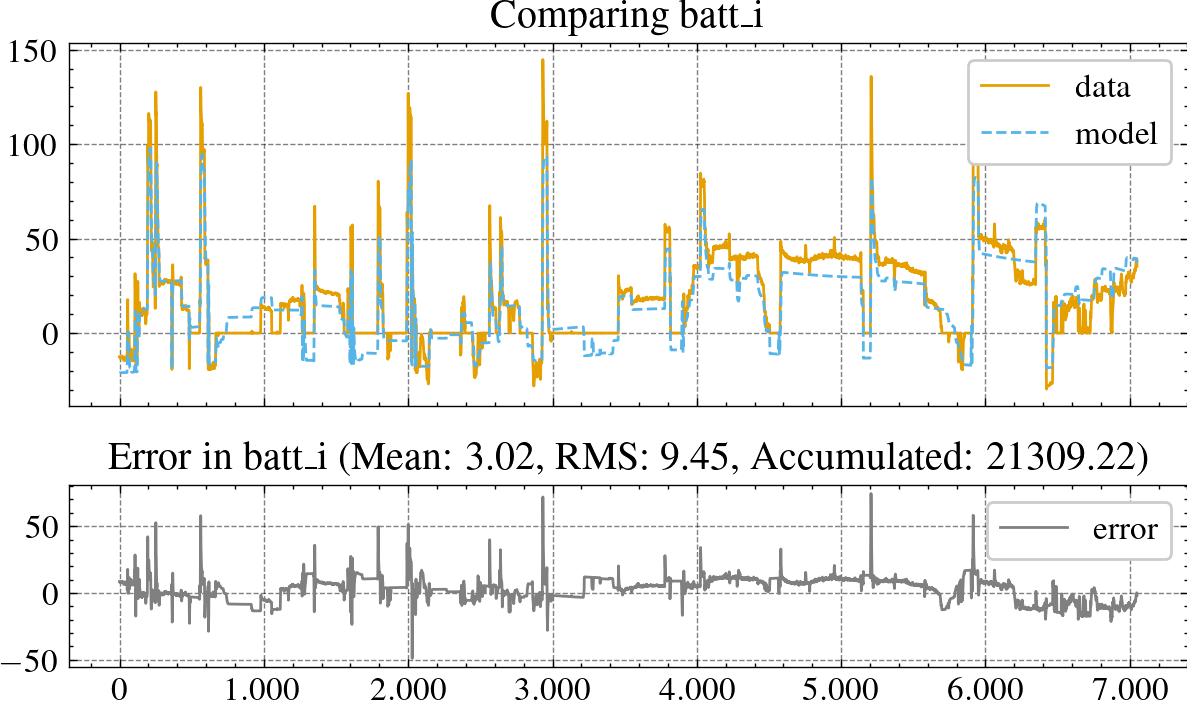

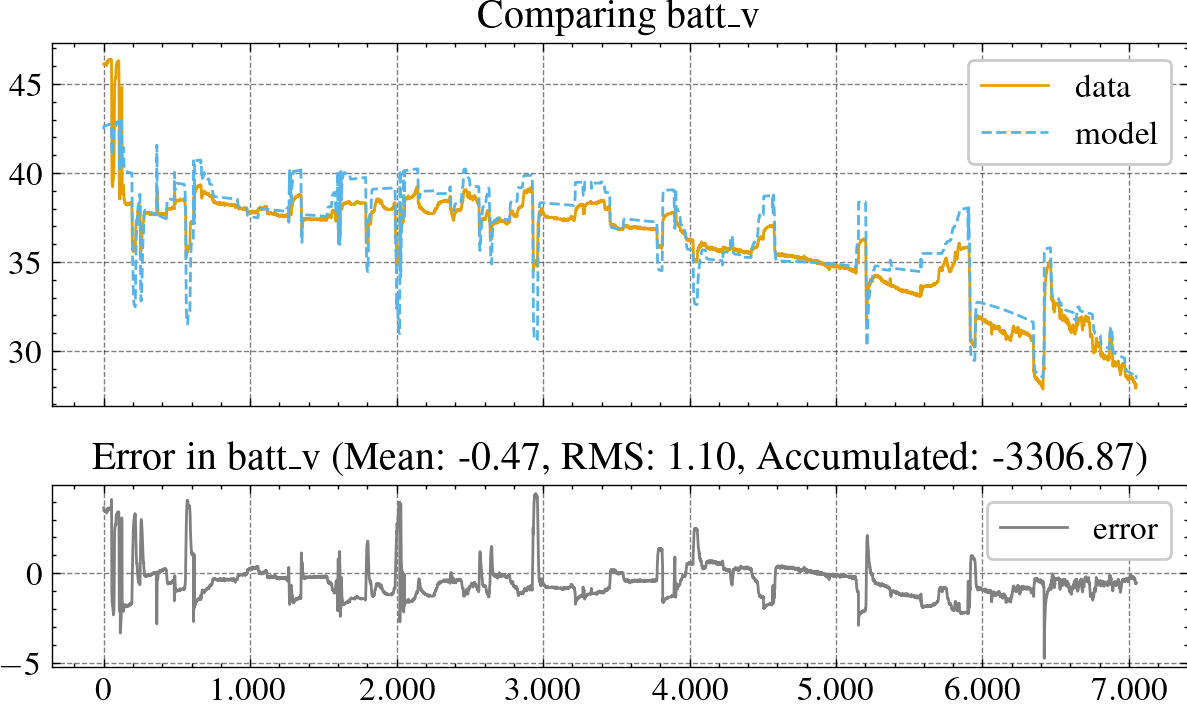

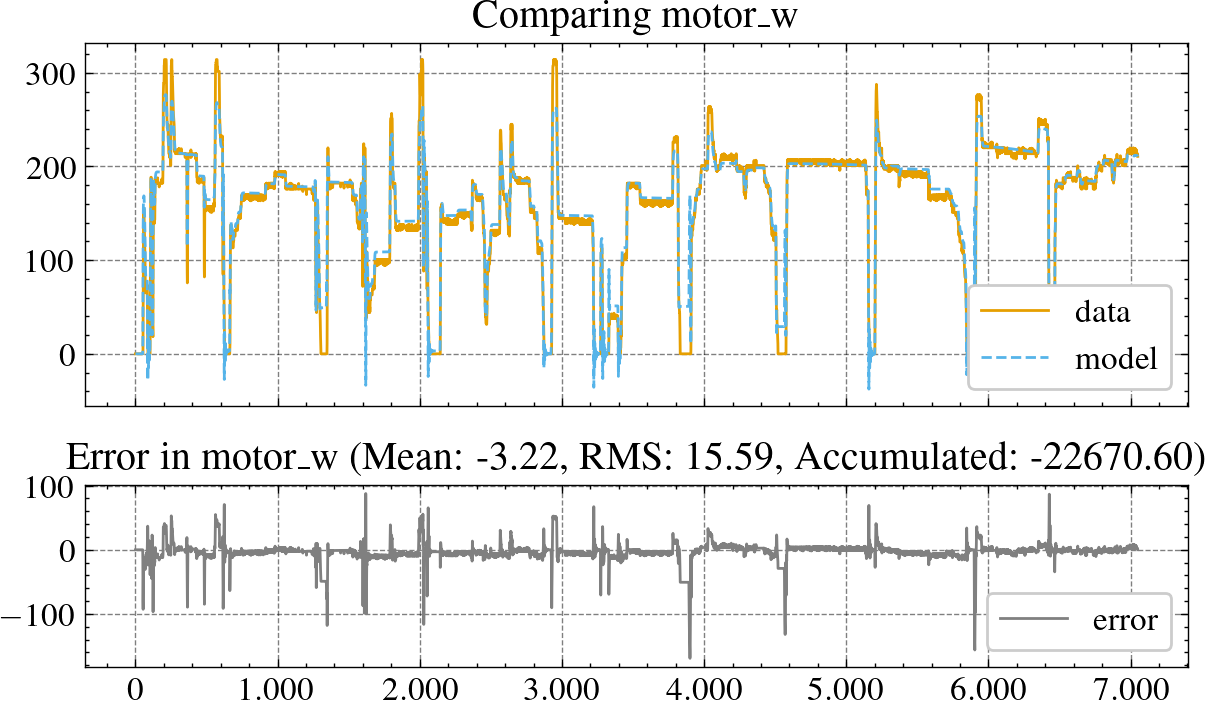

In [11]:
plot_compare(df, ydata, 'batt_i')
plot_compare(df, ydata, 'batt_v')
plot_compare(df, ydata, 'motor_w')

In [12]:
break!

SyntaxError: invalid syntax (3129860982.py, line 1)

## Testing optimization strategy with synthetic data

In [13]:
df = dfa.copy(deep=True)
ydata[['solar_poa', 'esc_d']] = df[['solar_poa', 'esc_d']].to_numpy()
df = ydata[['batt_v', 'batt_i', 'esc_i_in', 'motor_w', 'solar_poa', 'esc_d']].copy(deep=True)
df

,batt_v,batt_i,esc_i_in,motor_w,solar_poa,esc_d
time,,,,,,
0.0,42.455306,-21.102369,0.000000,0.000000,953.534344,0.000000
1.0,42.618149,-21.020445,0.000000,0.000000,953.477416,0.000000
2.0,42.621984,-21.017237,0.000000,0.000000,953.419432,0.000000
3.0,42.625183,-21.014319,0.000000,0.000000,953.360387,0.000000
4.0,42.628374,-21.011381,0.000000,0.000000,953.300276,0.000000
...,...,...,...,...,...,...
7046.0,28.492831,39.341475,62.453471,211.571516,708.275441,0.847168
7047.0,28.487735,39.313177,62.434599,211.538385,708.431189,0.847168
7048.0,28.483689,39.275390,62.405376,211.490720,708.586570,0.847168


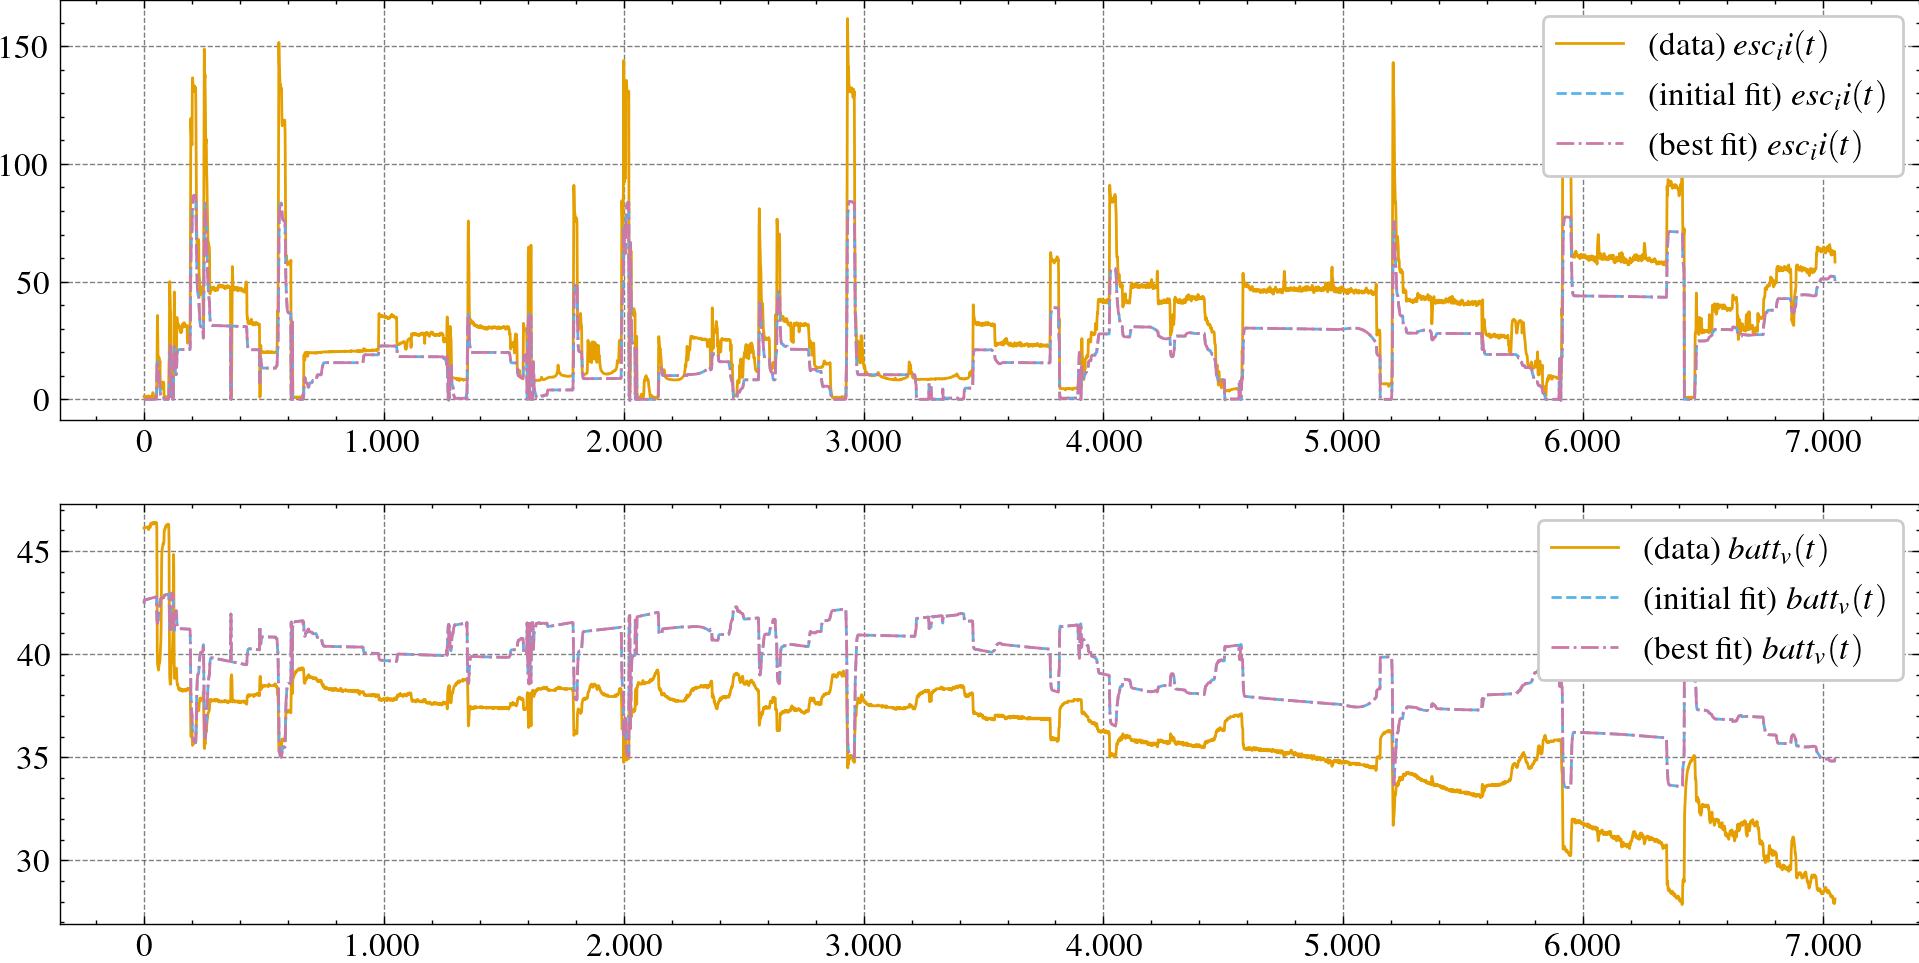

In [14]:
import random
random.seed(42)

def convert_params(params):
    if 'batt_ocv_coeff_0' not in params:
        return params

    n_coeffs = sum(1 for k in params if k.startswith('batt_ocv_coeff_'))
    return params | {'batt_k_V_OC_coeffs': [params[f'batt_ocv_coeff_{i}'] for i in range(n_coeffs)]}

def func(T, U, X0, **params):
    return ct.input_output_response(
        SolarBoat.build(params=solar_boat_params | convert_params(params)),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()[data_cols].to_numpy()


params = lmfit.Parameters()
# params.add('batt_eta', value=solar_boat_params['batt_eta'], min=0.1, max=1.0, vary=False)
# params.add('batt_Q', value=solar_boat_params['batt_Q'], min=solar_boat_params['batt_Q']*min_mult, max=solar_boat_params['batt_Q']*max_mult, vary=False)
# params.add('batt_R_0', value=solar_boat_params['batt_R_0']*random.random(), min=1e-6, max=0.1, vary=True, brute_step=0.01)
# params.add('batt_R_1', value=solar_boat_params['batt_R_1']*random.random(), min=1e-6, max=0.1, vary=True, brute_step=0.01)
# params.add('batt_C_1', value=solar_boat_params['batt_C_1']*random.random(), min=1, max=100, vary=True, brute_step=10)
# for i in range(0, len(solar_boat_params['batt_k_V_OC_coeffs'])):
#     params.add(f'batt_ocv_coeff_{i}', value=solar_boat_params['batt_k_V_OC_coeffs'][i]*random.random(), min=-1e3, max=1e3, vary=False)
# params.add('motor_R_A', value=solar_boat_params['motor_R_A']*random.random(), min=1e-3, max=0.1, vary=True, brute_step=0.01)
# params.add('motor_L_A', value=solar_boat_params['motor_L_A']*random.random(), min=1e-6, max=0.1, vary=True, brute_step=0.01)
# params.add('motor_B', value=solar_boat_params['motor_B']*random.random(), min=1e-3, max=1, vary=True, brute_step=0.1)
# params.add('motor_I_r', value=solar_boat_params['motor_I_r']*random.random(), min=1e-3, max=1, vary=True, brute_step=0.1)
# params.add('motor_I_r_load', value=solar_boat_params['motor_I_r_load']*random.random(), min=solar_boat_params['motor_I_r_load']*min_mult, max=solar_boat_params['motor_I_r_load']*max_mult, vary=False)
# params.add('motor_K_Q', value=solar_boat_params['motor_K_Q']*random.random(), min=solar_boat_params['motor_K_Q']*min_mult, max=solar_boat_params['motor_K_Q']*max_mult, vary=False)
params.add('prop_K_Q', value=solar_boat_params['prop_K_Q']*0.5, min=1e-4, max=1e-2, vary=True, brute_step=0.1)
# params.add('prop_D', value=solar_boat_params['prop_D']*random.random(), min=solar_boat_params['prop_D']*min_mult, max=solar_boat_params['prop_D']*max_mult, vary=False)
# params.add('rho_water', value=solar_boat_params['rho_water']*random.random(), min=solar_boat_params['rho_water']*min_mult, max=solar_boat_params['rho_water']*max_mult, vary=False)
# params.add('trans_eta', value=solar_boat_params['trans_eta']*random.random(), min=0.1, max=1.0, vary=False)
# params.add('esc_eta', value=solar_boat_params['esc_eta']*random.random(), min=0.1, max=1.0, vary=False)
# params.add('trans_k', value=solar_boat_params['trans_k']*random.random(), min=solar_boat_params['trans_k']*min_mult, max=solar_boat_params['trans_k']*max_mult, vary=False)

# display(params)

model = lmfit.Model(func=func, independent_vars=['T', 'U', 'X0'])

## Define data to fit
df = dfa.copy(deep=True)#[:1000]#.resample('30min').mean()
data_cols = ['esc_i_in', 'batt_v']
data = df[data_cols].copy(deep=True).to_numpy()

# Input data
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

U = df[['solar_poa', 'esc_d']].copy(deep=True).to_numpy().T

X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['batt_SOC']] = 1

# Optimize
result = model.fit(
    data=data,
    params=params,
    T=T,
    U=U,
    X0=X0,
    method='least_squares',
    # method='direct',
    # method='brute',
    # fit_kws=dict(
    #     workers=-1,
    # ),
    # max_nfev=1_000_000,
)

fig, ax = plt.subplots(result.data.shape[1], figsize=(12, 3*result.data.shape[1]))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = data_cols[i]

    ax[i].plot(data, label=f'(data) ${label}(t)$')
    ax[i].plot(initial, label=f'(initial fit) ${label}(t)$')
    ax[i].plot(best, label=f'(best fit) ${label}(t)$')
    ax[i].legend(loc=1)

plt.show()

result


In [15]:
break!

SyntaxError: invalid syntax (3129860982.py, line 1)

                        batt_v     batt_i    esc_i_in  motor_w  batt_v_fit  \
timestamp                                                                  
2020-01-31 14:22:30  46.112379 -12.441707  1.252184      0.0   42.455306   
2020-01-31 14:22:31  46.112379 -12.379807  1.496271      0.0   42.618148   
2020-01-31 14:22:32  46.112379 -12.891741  1.125766      0.0   42.621983   
2020-01-31 14:22:33  46.112379 -13.238582  1.036047      0.0   42.625180   
2020-01-31 14:22:34  46.150022 -13.183948  1.113614      0.0   42.628375   

                     batt_i_fit  esc_i_in_fit  motor_w_fit  
timestamp                                                 
2020-01-31 14:22:30  -21.102369         0.0          0.0  
2020-01-31 14:22:31  -21.020446         0.0          0.0  
2020-01-31 14:22:32  -21.017237         0.0          0.0  
2020-01-31 14:22:33  -21.014320         0.0          0.0  
2020-01-31 14:22:34  -21.011381         0.0          0.0  


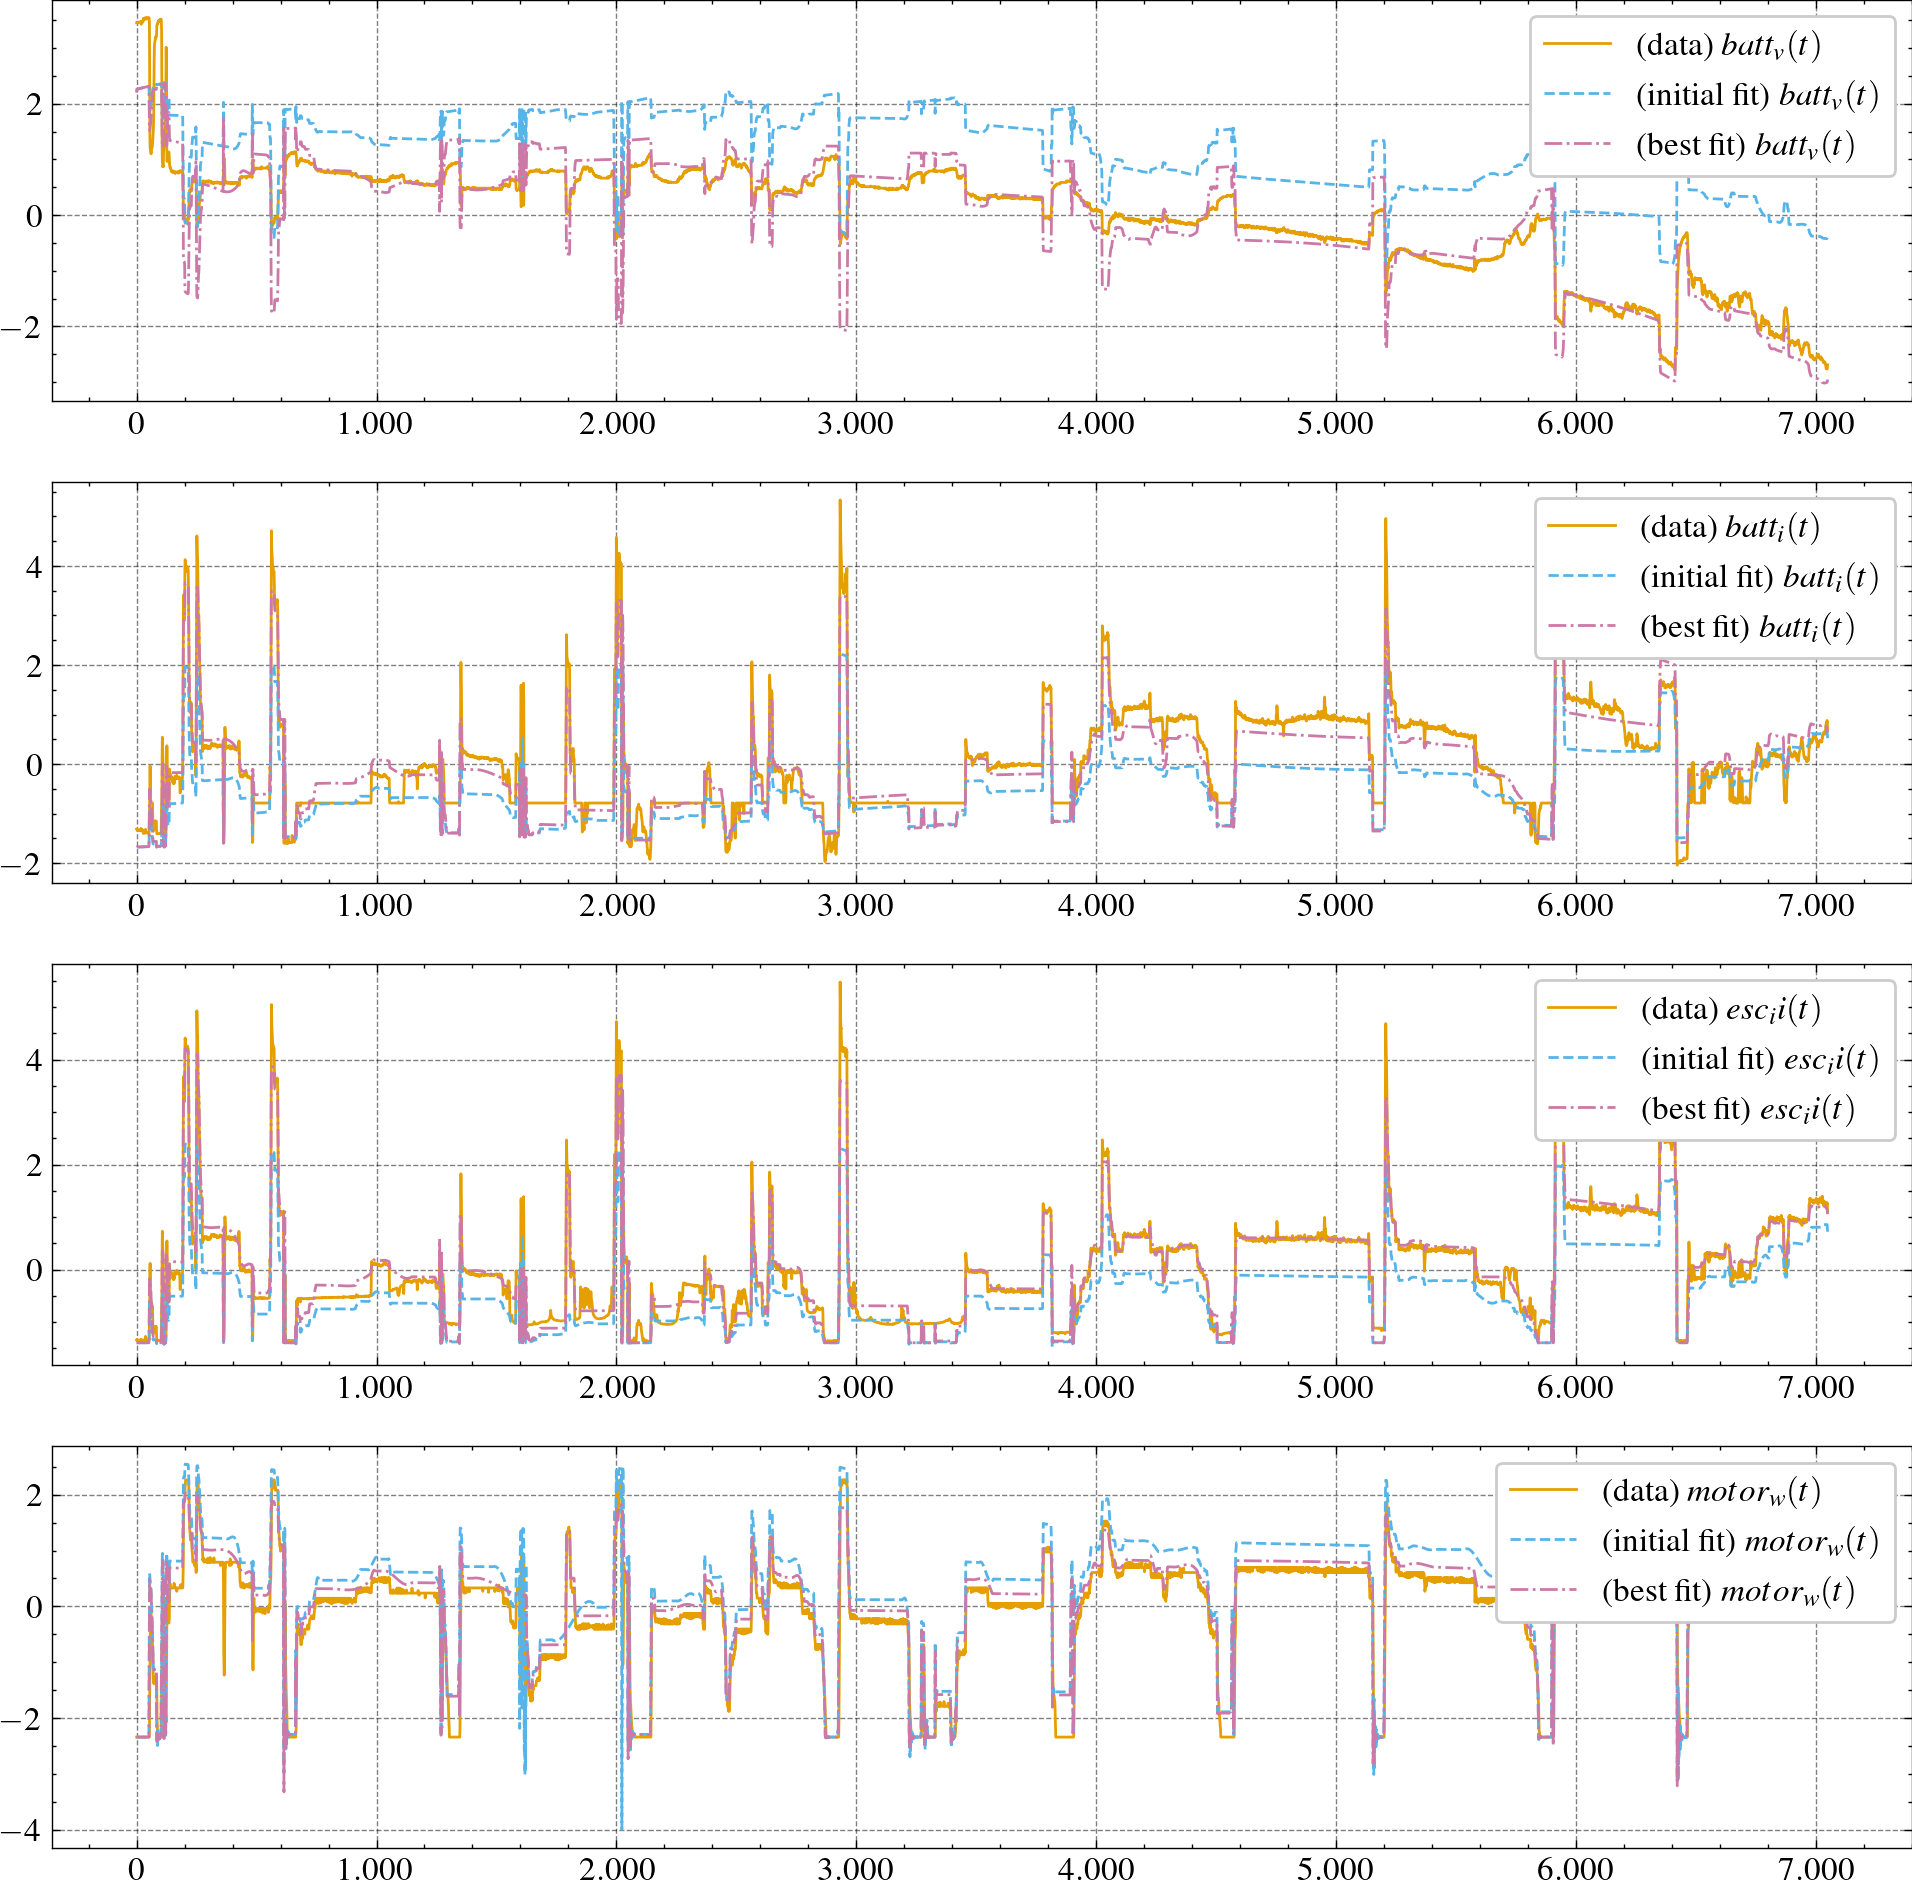

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

# Data Scaling Helpers
def scale_data(data, scaler=None):
    """Scales data using StandardScaler."""
    if scaler is None:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data = scaler.transform(data)
    return scaled_data, scaler

def rescale_data(data, scaler):
    """Rescales data back to the original scale."""
    return scaler.inverse_transform(data)

# Scale only the output data for optimization
data_cols = ['batt_v', 'batt_i', 'esc_i_in', 'motor_w']
data = df[data_cols].copy(deep=True).to_numpy()
data_scaled, data_scaler = scale_data(data)

# Define a wrapper for the non-scaled model
def func_scaled(T, U, X0, **params):
    # Generate model outputs using the non-scaled inputs
    model_output = ct.input_output_response(
        SolarBoat.build(params=solar_boat_params | convert_params(params)),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()[data_cols].to_numpy()

    # Scale the model outputs to match scaled optimization targets
    scaled_output, _ = scale_data(model_output, data_scaler)
    return scaled_output

# Initialize Parameters
params = lmfit.Parameters()
params.add('prop_K_Q', value=solar_boat_params['prop_K_Q'] * 0.5, min=1e-6, max=1e-2, vary=True)
params.add('motor_R_A', value=solar_boat_params['motor_R_A']*0.5, min=1e-3, max=1, vary=True)
params.add('motor_L_A', value=solar_boat_params['motor_L_A']*0.5, min=1e-6, max=0.1, vary=True)
params.add('motor_B', value=solar_boat_params['motor_B']*0.5, min=1e-3, max=1, vary=True)
params.add('motor_I_r', value=solar_boat_params['motor_I_r']*0.5, min=1e-3, max=1, vary=True)
# params.add('motor_I_r_load', value=solar_boat_params['motor_I_r_load']*0.5, min=solar_boat_params['motor_I_r_load']*min_mult, max=solar_boat_params['motor_I_r_load']*max_mult, vary=True)

# Build Model
model = lmfit.Model(func=func_scaled, independent_vars=['T', 'U', 'X0'])

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)

# Input data (non-scaled)
U = df[['solar_poa', 'esc_d']].copy(deep=True).to_numpy().T

# Initial state
X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['batt_SOC']] = 1

# Optimize using scaled target data
result = model.fit(
    data=data_scaled,  # Scaled optimization target
    params=params,
    T=T,
    U=U,
    X0=X0,
    # method='powell', #FAILS
    # method='TNC', # FAILS
    # method='Nelder-Mead', fit_kws=dict(options=dict(adaptive=False)), #~5.5min
    # method='trust-region', # ~5.5min
    # method='Basin-Hopping', # ~5.5min
    # method='COBYQA', # ~5.5min
    # method='SLSQP', # ~2.5min
    # method='COBYLA', ~1min
    # method='shgo', fit_kws=dict(workers=-1, minimizer_kwargs=dict(method='COBYLA')), # ~1min
    # method='shgo', fit_kws=dict(workers=-1, minimizer_kwargs=dict(method='COBYQA')), # ~55s
    # method='dual_annealing', fit_kws=dict(minimizer_kwargs=dict(method='COBYQA')), #
    method='Nelder-Mead', fit_kws=dict(options=dict(adaptive=True)), #~50s@1var, ~23min@3vars, ~50min@5vars
)

# Rescale fitted outputs to the original data scale
fit_result_scaled = func_scaled(T, U, X0, **result.params)
fit_result_rescaled = rescale_data(fit_result_scaled, data_scaler)

# Compare original vs. fit
df_fit = pd.DataFrame(fit_result_rescaled, columns=data_cols, index=df.index)
df_comparison = pd.concat([df[data_cols], df_fit.add_suffix('_fit')], axis=1)
print(df_comparison.head())
display(result)

fig, ax = plt.subplots(result.data.shape[1], figsize=(12, 3*result.data.shape[1]))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = data_cols[i]

    ax[i].plot(data, label=f'(data) ${label}(t)$')
    ax[i].plot(initial, label=f'(initial fit) ${label}(t)$')
    ax[i].plot(best, label=f'(best fit) ${label}(t)$')
    ax[i].legend(loc=1)

plt.show()


## Optimization: trying to optimize the entire system at once

In [17]:
df = dfa.copy(deep=True)
df['mppts_i_out'] = df['mppt1_io'] + df['mppt2_io'] + df['mppt3_io'] + df['mppt4_io']
dfa = df.copy(deep=True)

In [18]:
def convert_params(params):
    if 'batt_ocv_coeff_0' not in params:
        return params

    n_coeffs = sum(1 for k in params if k.startswith('batt_ocv_coeff_'))
    return params | {'batt_k_V_OC_coeffs': [params[f'batt_ocv_coeff_{i}'] for i in range(n_coeffs)]}

def func(T, U, X0, **params):
    return ct.input_output_response(
        SolarBoat.build(params=solar_boat_params | convert_params(params)),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()[data_cols].to_numpy()

params = lmfit.Parameters()
# params.add('batt_eta', value=solar_boat_params['batt_eta'], min=0.1, max=1.0, vary=False)
# params.add('batt_Q', value=solar_boat_params['batt_Q'], min=solar_boat_params['batt_Q']*min_mult, max=solar_boat_params['batt_Q']*max_mult, vary=False)
# params.add('batt_R_0', value=solar_boat_params['batt_R_0'], min=1e-6, max=0.1, vary=True, brute_step=0.01)
# params.add('batt_R_1', value=solar_boat_params['batt_R_1'], min=1e-6, max=0.1, vary=True, brute_step=0.01)
# params.add('batt_C_1', value=solar_boat_params['batt_C_1'], min=1, max=100, vary=True, brute_step=10)
# for i in range(0, len(solar_boat_params['batt_k_V_OC_coeffs'])):
#     params.add(f'batt_ocv_coeff_{i}', value=solar_boat_params['batt_k_V_OC_coeffs'][i], min=-1e3, max=1e3, vary=False)
# params.add('motor_R_A', value=solar_boat_params['motor_R_A'], min=1e-3, max=0.1, vary=True, brute_step=0.01)
# params.add('motor_L_A', value=solar_boat_params['motor_L_A'], min=1e-6, max=0.1, vary=True, brute_step=0.01)
# params.add('motor_B', value=solar_boat_params['motor_B'], min=1e-3, max=1, vary=True, brute_step=0.1)
# params.add('motor_I_r', value=solar_boat_params['motor_I_r'], min=1e-3, max=1, vary=True, brute_step=0.1)
# params.add('motor_I_r_load', value=solar_boat_params['motor_I_r_load'], min=solar_boat_params['motor_I_r_load']*min_mult, max=solar_boat_params['motor_I_r_load']*max_mult, vary=False)
# params.add('motor_K_Q', value=solar_boat_params['motor_K_Q'], min=solar_boat_params['motor_K_Q']*min_mult, max=solar_boat_params['motor_K_Q']*max_mult, vary=False)
# params.add('prop_K_Q', value=solar_boat_params['prop_K_Q'], min=1e-3, max=0.1, vary=True, brute_step=0.1)
# params.add('prop_D', value=solar_boat_params['prop_D'], min=solar_boat_params['prop_D']*min_mult, max=solar_boat_params['prop_D']*max_mult, vary=False)
# params.add('rho_water', value=solar_boat_params['rho_water'], min=solar_boat_params['rho_water']*min_mult, max=solar_boat_params['rho_water']*max_mult, vary=False)
# params.add('trans_eta', value=solar_boat_params['trans_eta'], min=0.1, max=1.0, vary=False)
# params.add('esc_eta', value=solar_boat_params['esc_eta'], min=0.1, max=1.0, vary=False)
# params.add('trans_k', value=solar_boat_params['trans_k'], min=solar_boat_params['trans_k']*min_mult, max=solar_boat_params['trans_k']*max_mult, vary=False)


# display(params)

model = lmfit.Model(func=func, independent_vars=['T', 'U', 'X0'])

## Define data to fit
df = dfa.copy(deep=True)#[:1000]#.resample('30min').mean()
data_cols = ['esc_i_in', 'batt_v']
data = df[data_cols].copy(deep=True).to_numpy()

# Input data
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

U = df[['solar_poa', 'esc_d']].copy(deep=True).to_numpy().T

X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['batt_SOC']] = 1

In [19]:
# Optimize
result = model.fit(
    data=data,
    params=params,
    T=T,
    U=U,
    X0=X0,
    method='brute',
    fit_kws=dict(
        workers=-1,
    ),
    # max_nfev=1_000_000,
)

fig, ax = plt.subplots(result.data.shape[1], figsize=(12, 3*result.data.shape[1]))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = data_cols[i]

    ax[i].plot(data, label=f'(data) ${label}(t)$')
    ax[i].plot(initial, label=f'(initial fit) ${label}(t)$')
    ax[i].plot(best, label=f'(best fit) ${label}(t)$')
    ax[i].legend(loc=1)

plt.show()

result


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
break!

# Example of use: optimizing duty-cycle

In [ ]:
import numpy as np
from scipy import optimize
from tqdm import tqdm
import time

def fun(x, T, U, X0, final_SOC, tolerance):
    U[1] = np.ones_like(U[1]) * x
    soc = ct.input_output_response(
        SolarBoat.build(params=solar_boat_params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()[['batt_SOC']].to_numpy()[-1, 0]

    if abs(soc - final_SOC) <= tolerance:
        return 0
    else:
        return (soc - final_SOC)**2

def optimize_duty_cycle(df: pd.DataFrame, initial_SOC: float, final_SOC: float, tolerance = 0.01, bounds=(0, 1), grid=10):
    # Input data
    T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9
    lenT = len(df.index)
    T = np.linspace(0, lenT * T, lenT, endpoint=False)

    U = df[['solar_poa', 'esc_d']].copy(deep=True).to_numpy().T

    X0 = np.zeros(solar_boat.nstates)
    X0[solar_boat.state_index['batt_SOC']] = initial_SOC

    result = optimize.brute(
        fun,
        ranges=[bounds],
        args=(T, U, X0, final_SOC, tolerance),
        Ns=grid, # grid
        full_output=False,
        workers=-1,
        finish=optimize.fmin,
    )
    optimized_esc_dt = result[0]

    # Evaluate
    U[1] = np.ones_like(U[1]) * optimized_esc_dt
    resulting_final_soc = ct.input_output_response(
        SolarBoat.build(params=solar_boat_params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()[['batt_SOC']].to_numpy()[-1][0]

    return resulting_final_soc, optimized_esc_dt

def plot_dt_optimization(res):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    ax1.plot(res['esc_d'], res['desired_final_SOC'], label='desired')
    ax1.plot(res['esc_d'], res['achieved_final_SOC'], label='achieved')
    ax1.set_title(f'Comparing final_SOC')
    ax1.legend()
    ax1.set_ylabel('Final SOC')
    ax1.set_xlabel('ESC Duty Cycle')

    error = res['desired_final_SOC'].to_numpy() - res['achieved_final_SOC'].to_numpy()

    ax2.plot(res['esc_d'], error, label='error', color='gray')

    mean_error = np.mean(error)
    rms_error = np.sqrt(np.mean(error**2))
    accumulated_error = np.sum(error)

    ax2.set_title(f'Error in final_SOC (Mean: {mean_error:.2f}, RMS: {rms_error:.2f}, Accumulated: {accumulated_error:.2f})')
    ax2.legend()

    plt.suptitle('Optimal ESC Duty Cycle for a desired Battery Final SOC')
    plt.tight_layout()
    plt.show()


initial_SOC = 1
final_SOCs = np.linspace(0, 1, 20)
res = []

total_iterations = len(final_SOCs)

with tqdm(total=total_iterations, desc="Processing", unit="iteration") as pbar:
    start_time = time.time()  # Start time for average runs per minute calculation

    for final_SOC in final_SOCs:

        soc, dt = optimize_duty_cycle(df, initial_SOC, final_SOC)

        res.append((final_SOC, soc, dt, soc - final_SOC))

        # Update progress bar
        pbar.update(1)

        # Update average runs per minute
        elapsed_time = time.time() - start_time
        avg_runs_per_minute = pbar.n / (elapsed_time / 60)
        pbar.set_postfix(avg_runs_per_minute=avg_runs_per_minute)

res = pd.DataFrame(res, columns=['desired_final_SOC', 'achieved_final_SOC', 'esc_d', 'error'])

plot_dt_optimization(res)

res

# Example of duty-cycle optimization under arbitrary conditions
Multiple arbitrary:
  - Race durations
  - Irradiation conditions
  - Battery final SOC


In [ ]:
from datetime import timedelta, datetime
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

race_durations = np.array([
    timedelta(minutes=5),
    timedelta(minutes=15),
    timedelta(minutes=30),
    timedelta(minutes=45),
    timedelta(hours=1),
    timedelta(hours=1.5),
    timedelta(hours=2),
    timedelta(hours=2.5),
    timedelta(hours=3),
    timedelta(hours=3.5),
    timedelta(hours=4),
    timedelta(hours=5),
])

irradiations = np.linspace(0, 1200, 21, endpoint=True)
initial_SOC = 1
final_SOCs = np.linspace(0, 1, 21)
start_date = datetime(year=2024, month=6, day=16, hour=10)
res = []

total_iterations = len(final_SOCs) * len(race_durations) * len(irradiations)

with tqdm(total=total_iterations, desc="Processing", unit="iteration") as pbar:
    start_time = time.time()  # Start time for average runs per minute calculation

    for (final_SOC, race_duration, irradiation) in itertools.product(final_SOCs, race_durations, irradiations):

        timestamp = pd.date_range(start=start_date, end=start_date + race_duration, freq='min')

        solar_poa = np.ones(timestamp.shape) * irradiation
        esc_d = np.zeros(timestamp.shape)
        df = pd.DataFrame(dict(timestamp=timestamp, solar_poa=solar_poa, esc_d=esc_d)).set_index('timestamp')

        try:
            soc, dt = optimize_duty_cycle(df, initial_SOC, final_SOC)
            error = soc - final_SOC
        except RuntimeError as e:
            soc, dt = None, None
            error = None

        res.append((final_SOC, soc, dt, error, race_duration, irradiation))

        # Update progress bar
        pbar.update(1)

        # Update average runs per minute
        elapsed_time = time.time() - start_time
        avg_runs_per_minute = pbar.n / (elapsed_time / 60)
        pbar.set_postfix(avg_runs_per_minute=avg_runs_per_minute)

res = pd.DataFrame(res, columns=['desired_final_SOC', 'achieved_final_SOC', 'esc_d', 'error', 'race_duration', 'irradiation']).dropna()
res.to_csv('optimize_duty_cycle.csv', index=False)
res


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

res = pd.read_csv('optimize_duty_cycle2.csv')
res['race_duration'] = pd.to_timedelta(res['race_duration'])
res.replace([np.inf, -np.inf], np.nan, inplace=True)
res.dropna(inplace=True)

# Convert race_duration to hours for plotting
res['race_duration'] = res['race_duration'].dt.total_seconds() / 3600

# Unique desired_final_SOC values
desired_final_SOCs = res['desired_final_SOC'].unique()
# desired_final_SOCs = np.append(desired_final_SOCs[::3], desired_final_SOCs[-1])

xmin, xmax = res['race_duration'].min(), res['race_duration'].max()
ymin, ymax = res['irradiation'].min(), res['irradiation'].max()
zmin, zmax = res['esc_d'].min(), res['esc_d'].max()

for desired_final_SOC in desired_final_SOCs:
    # Filter data for current desired_final_SOC
    grouped_res = res[res['desired_final_SOC'] == desired_final_SOC].copy(deep=True).groupby(['race_duration', 'irradiation']).mean().reset_index()

    # Create grid for interpolation
    samples = 20
    race_duration_high_freq = np.linspace(grouped_res['race_duration'].min(), grouped_res['race_duration'].max(), samples)
    irradiation_high_freq = np.linspace(grouped_res['irradiation'].min(), grouped_res['irradiation'].max(), samples)
    race_durations_grid, irradiations_grid = np.meshgrid(race_duration_high_freq, irradiation_high_freq)

    # Interpolate esc_d values using griddata
    esc_d_grid = griddata((grouped_res['race_duration'], grouped_res['irradiation']), grouped_res['esc_d'],
                        (race_durations_grid, irradiations_grid), method='linear')

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(race_durations_grid, irradiations_grid, esc_d_grid, cmap='viridis', edgecolor='none')

    # Labels
    ax.set_xlabel('Race Duration (hours)')
    ax.set_ylabel('Irradiation')
    ax.set_zlabel('esc_d')

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

    # Title
    ax.set_title('Trisurf plot of esc_d, race_duration, and irradiation (Simpson Interpolation)')

    # Add color bar which maps values to colors
    # fig.colorbar(trisurf, shrink=0.5, aspect=5)

    plt.tight_layout()

    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

res = pd.read_csv('optimize_duty_cycle2.csv')
res['race_duration'] = pd.to_timedelta(res['race_duration'])
res.replace([np.inf, -np.inf], np.nan, inplace=True)
res.dropna(inplace=True)

# Convert race_duration to hours for plotting
res['race_duration'] = res['race_duration'].dt.total_seconds() / 3600

# Unique desired_final_SOC values
desired_final_SOCs = res['desired_final_SOC'].unique()
desired_final_SOCs = np.append(desired_final_SOCs[::3], desired_final_SOCs[-1])

xmin, xmax = res['race_duration'].min(), res['race_duration'].max()
ymin, ymax = res['irradiation'].min(), res['irradiation'].max()
zmin, zmax = res['esc_d'].min(), res['esc_d'].max()

# Number of desired_final_SOC values
num_plots = len(desired_final_SOCs)

# Define constants
max_rows = 4
num_cols = 4
plots_per_fig = max_rows * num_cols

# Calculate the number of figures needed
num_figs = (num_plots + plots_per_fig - 1) // plots_per_fig

for fig_idx in range(num_figs):
    # Determine the range of SOCs for this figure
    start_idx = fig_idx * plots_per_fig
    end_idx = min(start_idx + plots_per_fig, num_plots)
    current_SOCs = desired_final_SOCs[start_idx:end_idx]

    # Calculate number of rows needed for the current figure
    num_rows = (len(current_SOCs) + num_cols - 1) // num_cols

    # Create figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, subplot_kw={'projection': '3d'}, squeeze=True)
    axs = axs.flatten()

    for i, desired_final_SOC in enumerate(current_SOCs):
        # Filter data for current desired_final_SOC
        grouped_res = res[res['desired_final_SOC'] == desired_final_SOC].copy(deep=True).groupby(['race_duration', 'irradiation']).mean().reset_index()

        # Create grid for interpolation
        samples = 20
        race_duration_high_freq = np.linspace(grouped_res['race_duration'].min(), grouped_res['race_duration'].max(), samples)
        irradiation_high_freq = np.linspace(grouped_res['irradiation'].min(), grouped_res['irradiation'].max(), samples)
        race_durations_grid, irradiations_grid = np.meshgrid(race_duration_high_freq, irradiation_high_freq)

        # Interpolate esc_d values using griddata
        esc_d_grid = griddata((grouped_res['race_duration'], grouped_res['irradiation']), grouped_res['esc_d'],
                            (race_durations_grid, irradiations_grid), method='linear')

        # Plot 3D surface on the current subplot
        ax = axs[i]

        # Plot the surface
        # surf = ax.plot_trisurf(race_durations_grid.ravel(), irradiations_grid.ravel(), esc_d_grid.ravel(), cmap='viridis', edgecolor='none')
        surf = ax.plot_surface(race_durations_grid, irradiations_grid, esc_d_grid, cmap='viridis', edgecolor='none')

        # Labels
        # ax.set_xlabel('Race Duration (hours)', labelpad=4)
        # ax.set_ylabel('Irradiation', labelpad=4)
        # ax.set_zlabel('esc_d', labelpad=4)

        # Title
        ax.set_title(f'{desired_final_SOC:.2f}')

        # Set the same axis limits for all plots
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])


    # Hide unused subplots
    for j in range(len(current_SOCs), len(axs)):
        fig.delaxes(axs[j])

    # fig.get_layout_engine().set(w_pad=2 / 72, h_pad=2 / 72, hspace=0.2, wspace=0.2)

    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

df = pd.read_csv('optimize_duty_cycle2.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

df = df.set_index(['desired_final_SOC', 'irradiation'])[['esc_d', 'race_duration']].sort_index()

irradiations = [300, 600, 840, 1080, 1200]
final_SOCs = [0.0, 0.2, 0.5, 1.0]

for final_SOC in final_SOCs:

    plt.figure()

    for irradiation in irradiations:

        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        plt.plot(dfa['race_duration'], dfa['esc_d'], label=f'G={irradiation} [W/m²]')

    plt.legend()
    plt.title('$SOC_{final}$' + f' = {100 * final_SOC :.0f} [\%]')
    plt.xlabel('Race Duration [h]')
    plt.ylabel('Throttle')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('optimize_duty_cycle2.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

df = df.set_index(['desired_final_SOC', 'irradiation'])[['esc_d', 'race_duration']].sort_index()

irradiations = [0, 300, 600, 840, 1080, 1200]
final_SOCs = [0.0, 0.2, 0.5, 1.0]

# Determine the layout of subplots
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
axes = axes.flatten()

for i, final_SOC in enumerate(final_SOCs):
    ax = axes[i]

    for irradiation in irradiations:
        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        ax.plot(dfa['race_duration'], dfa['esc_d'], label=f'G = {irradiation} [W/m²]')

    ax.set_title('$SOC_{final}$' + f' = {100 * final_SOC :.0f} [\%]')
    ax.set_xlabel('Race Duration [h]')
    ax.set_ylabel('Throttle')

fig_save_and_show(filename=None, save_title='', show_title='Irradiation comparison for different $SOC_{final}$', ncol=3)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('optimize_duty_cycle2.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

df = df.set_index(['desired_final_SOC', 'irradiation'])[['race_duration', 'error']].sort_index()

irradiations = [0, 300, 600, 840, 1080, 1200]
final_SOCs = [0.0, 0.2, 0.5, 1.0]

# Determine the layout of subplots
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
axes = axes.flatten()

for i, final_SOC in enumerate(final_SOCs):
    ax = axes[i]

    for irradiation in irradiations:
        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        ax.plot(dfa['race_duration'], dfa['error'], label=f'G = {irradiation} [W/m²]')

    ax.set_title('$SOC_{final}$' + f' = {100 * final_SOC :.0f} [\%]')
    ax.set_xlabel('Race Duration [h]')
    ax.set_ylabel('Error')

fig_save_and_show(filename=None, save_title='', show_title='Irradiation comparison for different $SOC_{final}$', ncol=3)


In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

df = pd.read_csv('optimize_duty_cycle2.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

df = df.set_index(['desired_final_SOC', 'irradiation'])[['esc_d', 'race_duration']].sort_index()

irradiations = [300, 600, 840, 1080, 1200]
final_SOCs = [0.0, 0.2, 0.5, 1.0]

for irradiation in irradiations:

    plt.figure()

    for final_SOC in final_SOCs:

        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        plt.plot(dfa['race_duration'], dfa['esc_d'], label='SOC_{final}' + f' = {100 * final_SOC :.0f} [\%]')

    plt.legend()
    plt.title(f'G = {irradiation} [W/m²]')
    plt.xlabel('Race Duration [h]')
    plt.ylabel('Throttle')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('optimize_duty_cycle2.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

df = df.set_index(['desired_final_SOC', 'irradiation'])[['esc_d', 'race_duration']].sort_index()

irradiations = [0, 300, 600, 1200]
final_SOCs = [0.0, 0.1, 0.2, 0.5, 0.8, 1.0]

# Determine the layout of subplots
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
axes = axes.flatten()

for i, irradiation in enumerate(irradiations):
    ax = axes[i]

    for final_SOC in final_SOCs:
        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        ax.plot(dfa['race_duration'], dfa['esc_d'], label='SOC_{final}' + f' = {100 * final_SOC :.0f} [\%]')

    ax.set_title(f'G = {irradiation} [W/m²]')
    ax.set_xlabel('Race Duration [h]')
    ax.set_ylabel('Throttle')

fig_save_and_show(filename=None, save_title='', show_title='$SOC_{final}$ comparison for different Irradiation', ncol=3)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('optimize_duty_cycle2.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

df = df.set_index(['desired_final_SOC', 'irradiation'])[['race_duration', 'error']].sort_index()

irradiations = [0, 300, 600, 1200]
final_SOCs = [0.0, 0.1, 0.2, 0.5, 0.8, 1.0]

# Determine the layout of subplots
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
axes = axes.flatten()

for i, irradiation in enumerate(irradiations):
    ax = axes[i]

    for final_SOC in final_SOCs:
        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        ax.plot(dfa['race_duration'], dfa['error'], label='SOC_{final}' + f' = {100 * final_SOC :.0f} [\%]')

    ax.set_title(f'G = {irradiation} [W/m²]')
    ax.set_xlabel('Race Duration [h]')
    ax.set_ylabel('Throttle')

fig_save_and_show(filename=None, save_title='', show_title='$SOC_{final}$ comparison for different Irradiation', ncol=3)


In [ ]:
from datetime import timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('optimize_duty_cycle.csv')
df['race_duration'] = pd.to_timedelta(df['race_duration'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Convert race_duration to hours for plotting
df['race_duration'] = df['race_duration'].dt.total_seconds() / 3600

# Unique desired_final_SOC values
desired_final_SOCs = df['desired_final_SOC'].unique()

df = df.set_index(['desired_final_SOC', 'irradiation'])[['esc_d', 'race_duration']].sort_index()

irradiations = [0, 300, 600, 840, 1080, 1200]
final_SOCs = [0.0, 0.2, 0.5, 1.0]

# Determine the layout of subplots
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
axes = axes.flatten()

for i, final_SOC in enumerate(final_SOCs):
    ax = axes[i]

    for irradiation in irradiations:
        try:
            dfa = df.loc[pd.IndexSlice[final_SOC, irradiation], :]
        except KeyError:
            continue

        for race_duration in dfa['race_duration']:

            # Prepare data
            start_date = datetime(year=2024, month=6, day=16, hour=10)
            timestamp = pd.date_range(start=start_date, end=start_date + timedelta(minutes=race_duration), freq='min')

            if len(timestamp) <= 1:
                continue;

            for esc_d in df['esc_d']:

                solar_poa = np.ones(timestamp.shape) * irradiation

                esc_d = np.ones(timestamp.shape) * esc_d

                dfb = pd.DataFrame(dict(timestamp=timestamp, solar_poa=solar_poa, esc_d=esc_d)).set_index('timestamp')

                # Simulate
                T = (dfb.index[1] - dfb.index[0]).to_numpy().astype(np.float64) * 1e-9
                lenT = len(dfb.index)
                T = np.linspace(0, lenT * T, lenT, endpoint=False)
                U = dfb[['solar_poa', 'esc_d']].T
                X0 = np.zeros(solar_boat.nstates)
                X0[solar_boat.state_index['batt_SOC']] = initial_SOC
                dfc = ct.input_output_response(
                    SolarBoat.build(params=solar_boat_params),
                    T=T,
                    U=U,
                    X0=X0,
                    solve_ivp_method='Radau',
                ).to_pandas().mean()

                print(dfc)

                break
            break
        break

        # ax.plot(dfa['race_duration'].dt.total_seconds() / 3600, dfc['esc_d'], label=f'G = {irradiation} [W/m²]')

#     ax.set_title('$SOC_{final}$' + f' = {100 * final_SOC :.0f} [\%]')
#     ax.set_xlabel('Race Duration [h]')
#     ax.set_ylabel('Throttle')

# fig_save_and_show(filename=None, save_title='', show_title='Irradiation comparison for different $SOC_{final}$', ncol=3)


In [55]:
[(-np.inf, np.inf)] * deg
np.zeros(deg + 1)

array([0., 0., 0., 0.])

In [ ]:
import numpy as np
import scipy


def objective(x_range, y_range, deg):
    x_range = np.array(x_range)
    y_range = np.array(y_range)

    def func(coefficients):
        y_range_hat = [np.polynomial.Polynomial(coefficients)(x) for x in x_range]
        return np.sum((y_range_hat - y_range)**2)

    return scipy.optimize.minimize(
        func,
        x0=np.zeros(deg + 1),  # Initialize with zeros,
        method='SLSQP',
        bounds=[(-np.inf, np.inf)] * (deg + 1)
    )

x_range = [-10, 10]
y_range = [0, 100]
deg = 1  # Order of polynomial

res = objective(x_range, y_range, deg)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7.624701948442301e-11
       x: [ 5.000e+01  5.000e+00]
     nit: 3
     jac: [ 1.168e-05  2.207e-04]
    nfev: 13
    njev: 3

In [66]:
x = np.arange(x_range[0], x_range[1]+1)

np.polynomial.Polynomial(res.x)(x)

array([-2.53154693e-06,  4.99999801e+00,  9.99999856e+00,  1.49999991e+01,
        1.99999996e+01,  2.50000002e+01,  3.00000007e+01,  3.50000013e+01,
        4.00000018e+01,  4.50000024e+01,  5.00000029e+01,  5.50000035e+01,
        6.00000040e+01,  6.50000045e+01,  7.00000051e+01,  7.50000056e+01,
        8.00000062e+01,  8.50000067e+01,  9.00000073e+01,  9.50000078e+01,
        1.00000008e+02])